In [ ]:
#|hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#! pip install rarfile av
#! pip install -Uq pyopenssl

# Image sequences

> How to use fastai to train an image sequence to image sequence job.

This tutorial uses fastai to process sequences of images. We are going to look at two tasks:

- First we will do video classification on the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php). You will learn how to convert the video to individual frames. We will also build a data processing piepline using fastai's mid level API.
- Secondly we will build some simple models and assess our accuracy.
- Finally we will train a SotA transformer based architecture.

In [ ]:
from fastai.vision.all import *

## UCF101 Action Recognition

> UCF101 is an action recognition data set of realistic action videos, collected from YouTube, having 101 action categories. This data set is an extension of UCF50 data set which has 50 action categories.

_"With 13320 videos from 101 action categories, UCF101 gives the largest diversity in terms of actions and with the presence of large variations in camera motion, object appearance and pose, object scale, viewpoint, cluttered background, illumination conditions, etc, it is the most challenging data set to date. As most of the available action recognition data sets are not realistic and are staged by actors, UCF101 aims to encourage further research into action recognition by learning and exploring new realistic action categories"_

### setup

We have to download the UCF101 dataset from their website. It is a big dataset (6.5GB), if your connection is slow you may want to do this at night or in a terminal (to avoid blocking the notebook).  fastai's `untar_data` is not capable of downloading this dataset, so we will use `wget` and then unrar the files using `rarfile`.

`fastai`'s datasets are located inside `~/.fastai/archive`, we will download UFC101 there.

In [ ]:
#|slow
# !wget -P ~/.fastai/archive/ --no-check-certificate  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar 

> you can run this command on a terminal to avoid blocking the notebook

Let's make a function to`unrar` the downloaded dataset. This function is very similar to `untar_data`, but handles `.rar` files.

In [ ]:
from rarfile import RarFile
    
def unrar(fname, dest):
    "Extract `fname` to `dest` using `rarfile`"
    dest = URLs.path(c_key='data')/fname.name.withsuffix('') if dest is None else dest
    print(f'extracting to: {dest}')
    if not dest.exists():
        fname = str(fname)
        if fname.endswith('rar'):  
            with RarFile(fname, 'r') as myrar:
                myrar.extractall(dest.parent)
        else: 
            raise Exception(f'Unrecognized archive: {fname}')
        rename_extracted(dest)
    return dest

To be consistent, we will extract UCF dataset in `~/.fasta/data`. This is where fastai stores decompressed datasets.

In [ ]:
ucf_fname = Path.home()/'.fastai/archive/UCF101.rar'
dest = Path.home()/'.fastai/data/UCF101'

> unraring a large file like this one is very slow.

In [ ]:
#|slow
path = unrar(ucf_fname, dest)

extracting to: /home/tcapelle/.fastai/data/UCF101


The file structure of the dataset after extraction is one folder per action:

In [ ]:
path.ls()

(#101) [Path('/home/tcapelle/.fastai/data/UCF101/Hammering'),Path('/home/tcapelle/.fastai/data/UCF101/HandstandPushups'),Path('/home/tcapelle/.fastai/data/UCF101/HorseRace'),Path('/home/tcapelle/.fastai/data/UCF101/FrontCrawl'),Path('/home/tcapelle/.fastai/data/UCF101/LongJump'),Path('/home/tcapelle/.fastai/data/UCF101/GolfSwing'),Path('/home/tcapelle/.fastai/data/UCF101/ApplyEyeMakeup'),Path('/home/tcapelle/.fastai/data/UCF101/UnevenBars'),Path('/home/tcapelle/.fastai/data/UCF101/HeadMassage'),Path('/home/tcapelle/.fastai/data/UCF101/Kayaking')...]

inside, you will find  one video per instance, the videos are in `.avi` format. We will need to convert each video to a sequence of images to able to work with our fastai vision toolset.
> Note: torchvision has a built-in video reader that may be capable of simplifying this task

```
UCF101-frames

├── ApplyEyeMakeup
|   |── v_ApplyEyeMakeup_g01_c01.avi
|   ├── v_ApplyEyeMakeup_g01_c02.avi
|   |   ...
├── Hammering
|   ├── v_Hammering_g01_c01.avi
|   ├── v_Hammering_g01_c02.avi
|   ├── v_Hammering_g01_c03.avi
|   |   ...
...
├── YoYo
    ├── v_YoYo_g01_c01.avi
    ...
    ├── v_YoYo_g25_c03.avi

```

we can grab all videos at one using `get_files` and passing the `'.avi` extension

In [ ]:
video_paths = get_files(path, extensions='.avi')
video_paths[0:4]

(#4) [Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g22_c05.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g21_c05.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g03_c03.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g18_c02.avi')]

We can convert the videos to frames using `av`:

In [ ]:
import av

In [ ]:
def extract_frames(video_path):
    "convert video to PIL images "
    video = av.open(str(video_path))
    for frame in video.decode(0):
        yield frame.to_image()

In [ ]:
frames = list(extract_frames(video_paths[0]))
frames[0:4]

[<PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>]

We have`PIL.Image` objects, so we can directly show them using fastai's `show_images` method

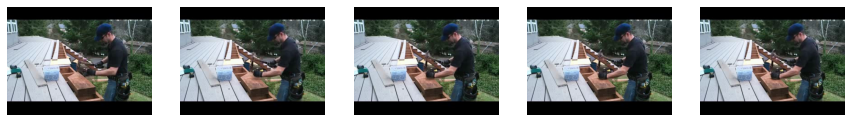

In [ ]:
show_images(frames[0:5])

let's grab one video path

In [ ]:
video_path = video_paths[0]
video_path

Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g22_c05.avi')

We want to export all videos to frames, les't built a function that is capable of exporting one video to frames, and stores the resulting frames on a folder of the same name.

Let's grab de folder name:

In [ ]:
video_path.relative_to(video_path.parent.parent).with_suffix('')

Path('Hammering/v_Hammering_g22_c05')

we will also create a new directory for our `frames` version of UCF. You will need at least 7GB to do this, afterwards you can erase the original UCF101 folder containing the videos.

In [ ]:
path_frames = path.parent/'UCF101-frames'
if not path_frames.exists(): path_frames.mkdir()

we will make a function that takes a video path, and extracts the frames to our new `UCF-frames` dataset with the same folder structure.

In [ ]:
def avi2frames(video_path, path_frames=path_frames, force=False):
    "Extract frames from avi file to jpgs"
    dest_path = path_frames/video_path.relative_to(video_path.parent.parent).with_suffix('')
    if not dest_path.exists() or force:
        dest_path.mkdir(parents=True, exist_ok=True)
        for i, frame in enumerate(extract_frames(video_path)):
            frame.save(dest_path/f'{i}.jpg')

In [ ]:
avi2frames(video_path)
(path_frames/video_path.relative_to(video_path.parent.parent).with_suffix('')).ls()

(#161) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/63.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/90.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/19.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/111.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/132.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/59.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/46.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/130.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/142.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/39.jpg')...]

Now we can batch process the whole dataset using fastcore's `parallel`. This could be slow on a low CPU count machine. On a 12 core machine it takes 4 minutes.

In [ ]:
#|slow
#parallel(avi2frames, video_paths)

after this you get a folder hierarchy that looks like this

```
UCF101-frames

├── ApplyEyeMakeup
|   |── v_ApplyEyeMakeup_g01_c01
|   │   ├── 0.jpg
|   │   ├── 100.jpg
|   │   ├── 101.jpg
|   |   ...
|   ├── v_ApplyEyeMakeup_g01_c02
|   │   ├── 0.jpg
|   │   ├── 100.jpg
|   │   ├── 101.jpg
|   |   ...
├── Hammering
|   ├── v_Hammering_g01_c01
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
|   ├── v_Hammering_g01_c02
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
|   ├── v_Hammering_g01_c03
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
...
├── YoYo
    ├── v_YoYo_g01_c01
    │   ├── 0.jpg
    │   ├── 1.jpg
    │   ├── 2.jpg
    |   ...
    ├── v_YoYo_g25_c03
        ├── 0.jpg
        ├── 1.jpg
        ├── 2.jpg
        ...
        ├── 136.jpg
        ├── 137.jpg

```

## Data pipeline

we have converted all the videos to images, we are ready to start building our fastai data pieline

In [ ]:
data_path = Path.home()/'.fastai/data/UCF101-frames'
data_path.ls()[0:3]

(#3) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering'),Path('/home/tcapelle/.fastai/data/UCF101-frames/HandstandPushups'),Path('/home/tcapelle/.fastai/data/UCF101-frames/HorseRace')]

we have one folder per action category, and inside one folder per instance of the action. 

In [ ]:
def get_instances(path):
    " gets all instances folders paths"
    sequence_paths = []
    for actions in path.ls():
        sequence_paths += actions.ls()
    return sequence_paths

with this function we get individual instances of each action, **these are the image sequences that we need to clasiffy.**. We will build a pipeline that takes as input **instance path**'s.

In [ ]:
instances_path = get_instances(data_path)
instances_path[0:3]

(#3) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g07_c03'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g13_c07')]

we have to sort the video frames numerically. We will patch pathlib's `Path` class to return a list of files conttaines on a folde sorted numerically. It could be a good idea to modify fastcore's `ls` method with an optiional argument `sort_func`.

In [ ]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [ ]:
instances_path[0].ls_sorted()

(#187) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/0.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/1.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/2.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/3.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/4.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/5.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/6.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/7.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/8.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/9.jpg')...]

let's grab the first 5 frames

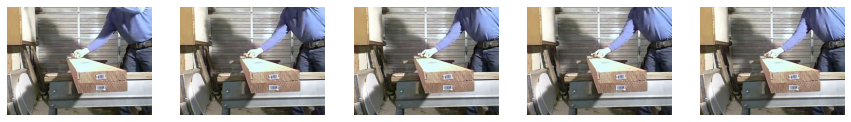

In [ ]:
frames = instances_path[0].ls_sorted()[0:5]
show_images([Image.open(img) for img in frames])

We will build a tuple that contains individual frames and that can show themself. We will use the same idea that on the `siamese_tutorial`. As a video can have many frames, and we don't want to display them all, the `show` method will only display the 1st, middle and last images.

In [ ]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

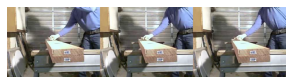

In [ ]:
ImageTuple(PILImage.create(fn) for fn in frames).show();

we will use the mid-level API to create our Dataloader from a transformed list. 

In [ ]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
tfm = ImageTupleTfm(seq_len=5)
hammering_instance = instances_path[0]
hammering_instance

Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02')

<AxesSubplot:>

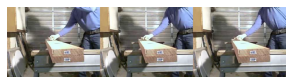

In [ ]:
tfm(hammering_instance).show()

with this setup, we can use the `parent_label` as our labelleing function

In [ ]:
parent_label(hammering_instance)

'Hammering'

In [ ]:
splits = RandomSplitter()(instances_path)

We will use fastai`Datasets` class, we have to pass a `list` of transforms. The first list `[ImageTupleTfm(5)]` is how we grab the `x`'s and the second list `[parent_label, Categorize]]` is how we grab the `y`'s.' So, from each instance path, we grab the first 5 images to construct an `ImageTuple` and we grad the label of the action from the parent folder using `parent_label` and the we `Categorize` the labels.

In [ ]:
ds = Datasets(instances_path, tfms=[[ImageTupleTfm(5)], [parent_label, Categorize]], splits=splits)

In [ ]:
len(ds)

13320

In [ ]:
dls = ds.dataloaders(bs=4, after_item=[Resize(128), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

refactoring

In [ ]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

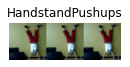

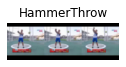

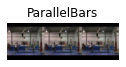

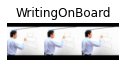

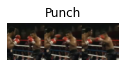

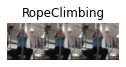

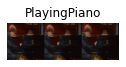

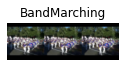

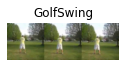

In [ ]:
dls = get_action_dataloaders(instances_path, bs=32, image_size=64, seq_len=5)
dls.show_batch()

## A Baseline Model

We will make a simple baseline model. It will encode each frame individually using a pretrained resnet. We make use of the `TimeDistributed` layer to apply the resnet to each frame identically. This simple model will just average the probabilities of each frame individually. A `simple_splitter` function is also provided to avoid destroying the pretrained weights of the encoder.

In [ ]:
class SimpleModel(Module):
    def __init__(self, arch=resnet34, n_out=101):
        self.encoder = TimeDistributed(create_body(arch, pretrained=True))
        self.head = TimeDistributed(create_head(512, 101))
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return self.head(self.encoder(x)).mean(dim=1)
    
def simple_splitter(model): return [params(model.encoder), params(model.head)]

> Note: We don't need to put a `sigmoid` layer at the end, as the loss function will fuse the Entropy with the sigmoid to get more numerical stability. Our models will output one value per category. you can recover the predicted class using `torch.sigmoid` and `argmax`.

In [ ]:
model = SimpleModel().cuda()

In [ ]:
x,y = dls.one_batch()

It is always a good idea to check what is going inside the model, and what is coming out.

In [ ]:
print(f'{type(x) = },\n{len(x) = } ,\n{x[0].shape = }, \n{model(x).shape = }')

type(x) = <class '__main__.ImageTuple'>,
len(x) = 5 ,
x[0].shape = (32, 3, 64, 64), 
model(x).shape = torch.Size([32, 101])


We are ready to create a Learner. The loss function is not mandatory, as the `DataLoader` already has the Binary Cross Entropy because we used a `Categorify` transform on the outputs when constructing the `Datasets`.

In [ ]:
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

We will make use of the `MixedPrecision` callback to speed up our training (by calling `to_fp16` on the learner object).
> Note: The `TimeDistributed` layer is memory hungry (it pivots the image sequence to the batch dimesion) so if you get OOM errors, try reducing the batchsize.

As this is a classification problem, we will monitor classification `accuracy`. You can pass the model splitter directly when creating the learner.

In [ ]:
learn = Learner(dls, model, metrics=[accuracy], splitter=simple_splitter).to_fp16()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.00363078061491251)

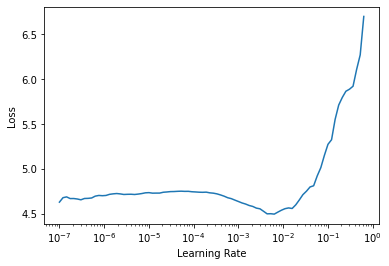

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,3.685684,3.246746,0.295045,00:19
1,2.467395,2.144252,0.477102,00:18
2,1.973236,1.784474,0.545420,00:19


epoch,train_loss,valid_loss,accuracy,time
0,1.467863,1.449896,0.626877,00:24
1,1.143187,1.200496,0.679805,00:24
2,0.941360,1.152383,0.696321,00:24


68% not bad for our simple baseline with only 5 frames.

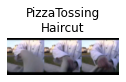

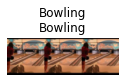

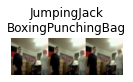

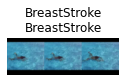

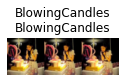

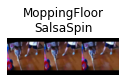

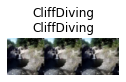

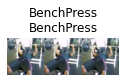

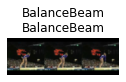

In [ ]:
learn.show_results()

We can improve our model by passing the outputs of the image encoder to an `nn.LSTM` to get some inter-frame relation. To do this, we have to get the features of the image encoder, so we have to modify our code and make use of the `create_body` function and add a pooling layer afterwards.

In [ ]:
arch = resnet34
encoder = nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()).cuda()

if we check what is the output of the encoder, for each image, we get a feature map of 512.

In [ ]:
encoder(x[0]).shape

(32, 512)

In [ ]:
tencoder = TimeDistributed(encoder)
tencoder(torch.stack(x, dim=1)).shape

(32, 5, 512)

this is perfect as input for a recurrent layer. Let's refactor and add a linear layer at the end. We will output the hidden state to a linear layer to compute the probabilities. The idea behind, is that the hidden state encodes the temporal information of the sequence.

In [ ]:
class RNNModel(Module):
    def __init__(self, arch=resnet34, n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

let's make a splitter function to train the encoder and the rest separetely

In [ ]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [ ]:
model2 = RNNModel().cuda()

In [ ]:
learn = Learner(dls, model2, metrics=[accuracy], splitter=rnnmodel_splitter).to_fp16()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0012022644514217973)

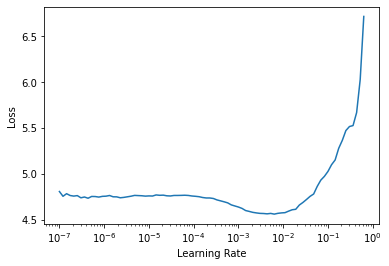

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.081921,2.968944,0.295796,00:19


epoch,train_loss,valid_loss,accuracy,time
0,1.965607,1.890396,0.516892,00:25
1,1.544786,1.648921,0.608108,00:24
2,1.007738,1.157811,0.702703,00:25
3,0.537038,0.885042,0.771772,00:24
4,0.351384,0.849636,0.781156,00:25


this models is harder to train. A good idea would be to add some Dropout. Let's try increasing the sequence lenght. Another approach would be to use a better layer for this type of task, like the [ConvLSTM](https://paperswithcode.com/method/convlstm) or a Transformer for images that are capable of modelling the spatio-temporal relations in a more sophisticated way.
Some ideas:

- Try sampling the frames differently, (randomly spacing, more frames, etc...)

## A Transformer Based models
> A quick tour on the new transformer based archs

There are a bunch of transformer based image models that have appeared recently after the introduction of the [Visual Transformer (ViT). ](https://github.com/google-research/vision_transformer). We currently have many variants of this architecture with nice implementation in pytorch integrated to [timm](https://github.com/rwightman/pytorch-image-models) and [@lucidrains](https://github.com/lucidrains/vit-pytorch) maintains a repository with all the variants and elegant pytorch implementations.

Recently the image models have been extended to video/image-sequences, hey use the transformer to encode space and time jointly. Here we will train the [TimeSformer](https://arxiv.org/abs/2102.05095) architecture on the action recognition task as it appears to be the easier to train from scratch. We will use [@lucidrains](https://github.com/lucidrains/TimeSformer-pytorch) implementation.

Currently we don't have access to pretrained models, but loading the `ViT` weights on some blocks could be possible, but it is not done here.



### Install

First things first, we will need to install the  model:

```
!pip install -Uq timesformer-pytorch
```

In [ ]:
from timesformer_pytorch import TimeSformer

### Train

the `TimeSformer` implementation expects a sequence of images in the form of: `(batch_size, seq_len, c, w, h)`. We need to wrap the model to stack the image sequence before feeding the forward method

In [ ]:
class MyTimeSformer(TimeSformer):
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return super().forward(x)

In [ ]:
timesformer = MyTimeSformer(
    dim = 128,
    image_size = 128,
    patch_size = 16,
    num_frames = 5,
    num_classes = 101,
    depth = 12,
    heads = 8,
    dim_head =  64,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).cuda()

In [ ]:
learn_tf = Learner(dls, timesformer, metrics=[accuracy]).to_fp16()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

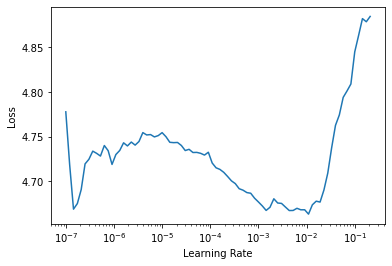

In [ ]:
learn_tf.lr_find()

In [ ]:
learn_tf.fit_one_cycle(12, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.227850,4.114154,0.091216,00:41
1,3.735752,3.694664,0.141517,00:42
2,3.160729,3.085824,0.256381,00:41
3,2.540461,2.478563,0.380255,00:42
4,1.878038,1.880847,0.536411,00:42
5,1.213030,1.442322,0.642643,00:42
6,0.744001,1.153427,0.720345,00:42
7,0.421604,1.041846,0.746997,00:42
8,0.203065,0.959380,0.779655,00:42
9,0.112700,0.902984,0.792042,00:42


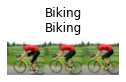

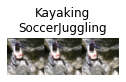

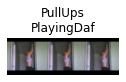

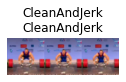

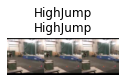

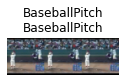

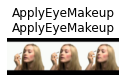

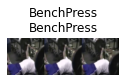

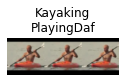

In [ ]:
learn_tf.show_results()